In [1]:
# Import dependencies
import tensorflow as tf
from tensorflow import keras

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pathlib
import PIL
import PIL.Image
import cv2

In [2]:
# Lets check your GPU
if tf.config.list_logical_devices('GPU') != []:
    print("LET'S DO THISS!!! :DDDD")
else: 
    print("Oh dude... D:")

LET'S DO THISS!!! :DDDD


# 1) Load data

In [3]:
'''

Lets define some dir to save iamges.

'''

from pathlib import Path

IMAGES_PATH = Path() / "images" / "generative"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [4]:
path = "./img_align_celeba"
data_dir = pathlib.Path(path)

# Lets check quantity
image_count = len(list(data_dir.glob('*.jpg')))
print('We have', image_count, 'images.')

We have 202599 images.


In [5]:
# Get all paths
all_paths = [str(x) for x in list(data_dir.glob('*.jpg'))]

## 1.1) Slice dataset in train-val-test

In [6]:
train_path = all_paths[:int(image_count * 0.8)]
val_path = all_paths[int(image_count * 0.8): int(image_count * 0.9)]
test_path = all_paths[int(image_count * 0.9):]

In [7]:
# Sanity check!
PIL.Image.open(train_path[0])

## 1.2) Let's preprocessing all images with tf dataset

In [8]:
# Instanciate tf datasets
ds_train_path = tf.data.Dataset.from_tensor_slices(train_path)
ds_val_path = tf.data.Dataset.from_tensor_slices(val_path)
ds_test_path = tf.data.Dataset.from_tensor_slices(test_path)

In [9]:
'''

Open all images and resize.

'''

def open_image(x):
    return tf.ensure_shape(tf.image.decode_image(tf.io.read_file(x)), [218, 178, 3])

def resize_image(x, n_outputs=2):
    if n_outputs == 2:
        return (tf.image.resize(x, [128, 128]) / 255., tf.image.resize(x, [128, 128]) / 255.)
    return tf.image.resize(x, [128, 128]) / 255.

ds_train = ds_train_path.map(
    lambda x: resize_image(open_image(x))
)

ds_val = ds_val_path.map(
    lambda x: resize_image(open_image(x))
)

ds_test = ds_test_path.map(
    lambda x: resize_image(open_image(x))
)

# 2) Load pre-trained model

In [10]:
class Sampling(tf.keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return tf.random.normal(tf.shape(log_var)) * tf.exp(log_var / 2) + mean 

In [11]:
custom_objects = {'Sampling': Sampling}

In [12]:
'''

Pre-trained models - Instructions about training you can find in another file

'''

variational_ae = keras.models.load_model('my_vae_celeba/autoencoder/vae_autoencoder.keras', custom_objects=custom_objects)
variational_encoder = keras.models.load_model('my_vae_celeba/encoder/vae_encoder.keras', custom_objects=custom_objects)
variational_decoder = keras.models.load_model('my_vae_celeba/decoder/vae_decoder.keras', custom_objects=custom_objects)

In [13]:
'''

Slice ds_train in batches

'''


dataset_train = ds_train.batch(128, drop_remainder=True).prefetch(1)
dataset_val = ds_val.batch(128, drop_remainder=True).prefetch(1)

In [14]:
for j in dataset_train.take(1):
    print(j[1].shape)

(128, 128, 128, 3)


In [15]:
'''

Define util functions to show images.

'''

from IPython.display import clear_output

def plot_multiple_images_without_k(images, n_cols=None, output_neural=False):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = images.squeeze(axis=-1)
    
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        
        if output_neural:
            plt.imshow(image, cmap="binary")
            clear_output()
        else:
            plt.imshow(image, cmap="binary")
        plt.axis("off")

def plot_multiple_images(images, n_cols=None, k=1):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = images.squeeze(axis=-1)
    plt.figure(figsize=(n_cols * k, n_rows * k))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        clear_output()
        plt.axis("off")

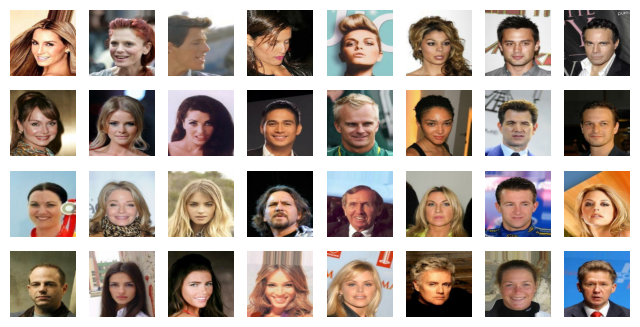

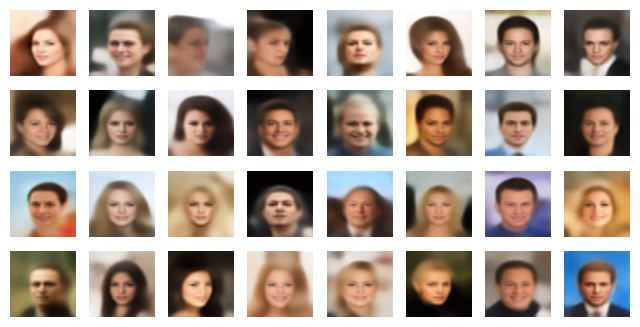

In [16]:
'''

Let's check sanity with models.

'''

for X_ds in dataset_train.take(1):
    plot_multiple_images_without_k(X_ds[0][:32], 8)
    plot_multiple_images_without_k(variational_ae(X_ds[0][:32]), 8, output_neural=True)

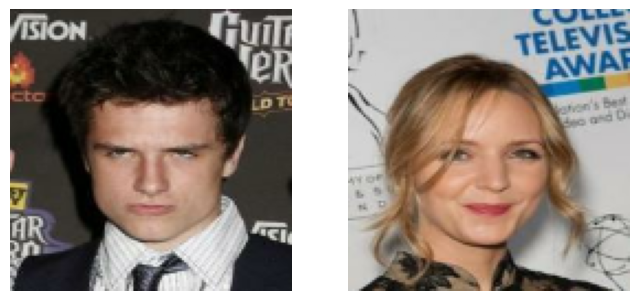

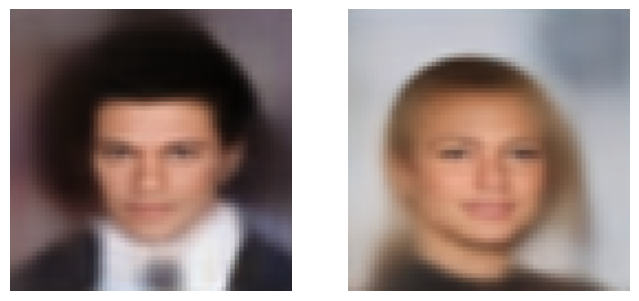

In [17]:
i = 90
for X_ds in dataset_train.take(1):
    plot_multiple_images(X_ds[0][i:i+2], 2, k=4)
    plot_multiple_images(variational_ae(X_ds[0][i:i+2]), 2, k=4)

### The regular VAE is ready! 

Let's use this architecture to make some cool applications in Deep Fake! First, lets open file about features in each images and use it.

In [18]:
df = pd.read_csv('list_attr_celeba.csv')

In [19]:
for column in df.columns[1:]:
    print('--------------------')
    print(df[column].value_counts(True))
    print('--------------------')

--------------------
-1    0.888864
 1    0.111136
Name: 5_o_Clock_Shadow, dtype: float64
--------------------
--------------------
-1    0.733019
 1    0.266981
Name: Arched_Eyebrows, dtype: float64
--------------------
--------------------
 1    0.512505
-1    0.487495
Name: Attractive, dtype: float64
--------------------
--------------------
-1    0.795428
 1    0.204572
Name: Bags_Under_Eyes, dtype: float64
--------------------
--------------------
-1    0.977557
 1    0.022443
Name: Bald, dtype: float64
--------------------
--------------------
-1    0.848425
 1    0.151575
Name: Bangs, dtype: float64
--------------------
--------------------
-1    0.759204
 1    0.240796
Name: Big_Lips, dtype: float64
--------------------
--------------------
-1    0.765468
 1    0.234532
Name: Big_Nose, dtype: float64
--------------------
--------------------
-1    0.760749
 1    0.239251
Name: Black_Hair, dtype: float64
--------------------
--------------------
-1    0.852008
 1    0.147992
Nam

Note, in this dataset, we have 42 features about appearance and things in the image. Let's remember our objective: We want to insert some fake feature (Bald, Wavy Hair, Smile...) in some instance. 

In [20]:
df.head(10)

image_id  5_o_Clock_Shadow  Arched_Eyebrows  Attractive  Bags_Under_Eyes  \
0  000001.jpg                -1                1           1               -1   
1  000002.jpg                -1               -1          -1                1   
2  000003.jpg                -1               -1          -1               -1   
3  000004.jpg                -1               -1           1               -1   
4  000005.jpg                -1                1           1               -1   
5  000006.jpg                -1                1           1               -1   
6  000007.jpg                 1               -1           1                1   
7  000008.jpg                 1                1          -1                1   
8  000009.jpg                -1                1           1               -1   
9  000010.jpg                -1               -1           1               -1   

   Bald  Bangs  Big_Lips  Big_Nose  Black_Hair  ...  Sideburns  Smiling  \
0    -1     -1        -1        -1          -1  ...         -1        1   
1    -1     -1        -1         1          -1  ...         -1        1   
2    -1     -1         1        -1          -1  ...         -1       -1   
3    -1     -1        -1        -1          -1  ...         -1       -1   
4    -1     -1         1        -1          -1  ...         -1       -1   
5    -1     -1         1        -1          -1  ...         -1       -1   
6    -1     -1         1         1           1  ...         -1       -1   
7    -1     -1         1        -1           1  ...         -1       -1   
8    -1      1         1        -1          -1  ...         -1        1   
9    -1     -1        -1        -1          -1  ...         -1       -1   

   Straight_Hair  Wavy_Hair  Wearing_Earrings  Wearing_Hat  Wearing_Lipstick  \
0              1         -1                 1           -1                 1   
1             -1         -1                -1           -1                -1   
2             -1          1                -1           -1                -1   
3              1         -1                 1           -1                 1   
4             -1         -1                -1           -1                 1   
5             -1          1                 1           -1                 1   
6              1         -1                -1           -1                -1   
7             -1         -1                -1           -1                -1   
8             -1         -1                 1           -1                 1   
9             -1          1                -1           -1                 1   

   Wearing_Necklace  Wearing_Necktie  Young  
0                -1               -1      1  
1                -1               -1      1  
2                -1               -1      1  
3                 1               -1      1  
4                -1               -1      1  
5                -1               -1      1  
6                -1               -1      1  
7                -1               -1      1  
8                -1               -1      1  
9                -1               -1      1  

[10 rows x 41 columns]

In [21]:
df['path'] = df['image_id'].apply(lambda x: 'img_align_celeba' + '\\' + x)
df['path']

0         img_align_celeba\000001.jpg
1         img_align_celeba\000002.jpg
2         img_align_celeba\000003.jpg
3         img_align_celeba\000004.jpg
4         img_align_celeba\000005.jpg
                     ...             
202594    img_align_celeba\202595.jpg
202595    img_align_celeba\202596.jpg
202596    img_align_celeba\202597.jpg
202597    img_align_celeba\202598.jpg
202598    img_align_celeba\202599.jpg
Name: path, Length: 202599, dtype: object

In [22]:
from tqdm import tqdm

In first case, lets use Bald feature in analysis

In [23]:
len(df[df['Bald'] == 1]['path'].values)

4547

In [24]:
Bald_att_1 = tf.data.Dataset.from_tensor_slices(df[df['Bald'] ==  1]['path'].values[:5000])
Bald_att_0 = tf.data.Dataset.from_tensor_slices(df[(df['Bald'] == -1) & (df['Male'] == 1)]['path'].values[:5000])

In [25]:
'''

We will here slice 2 subsets of all dataset and let's arrange in some class, in our case, we will use Bald feature.

'''


def open_image(x):
    return tf.ensure_shape(tf.image.decode_image(tf.io.read_file(x)), [218, 178, 3])

def resize_image(x, n_outputs=2):
    if n_outputs == 2:
        return (tf.image.resize(x, [128, 128]) / 255., tf.image.resize(x, [128, 128]) / 255.)
    elif n_outputs == 1:
        return tf.image.resize(x, [128, 128]) / 255.
    return 


ds_Bald_att_1 = Bald_att_1.map(
    lambda x: resize_image(open_image(x))
)

ds_Bald_att_0 = Bald_att_0.map(
    lambda x: resize_image(open_image(x))
)

## Encoding Images

When we encoding images, we transform to embedding (latent variable) in a vector with 32 dimensions. In other words, $z \in \mathbb{R}^{32}$.

In [26]:
'''

Let's encode all images!

'''

_, _, codings_att1_1 = variational_encoder.predict(ds_Bald_att_1.batch(32).prefetch(1))
_, _, codings_att1_0 = variational_encoder.predict(ds_Bald_att_0.batch(32).prefetch(1))

157/157 [==============================] - 1s 7ms/step


In [27]:
codings_att1_1.shape, codings_att1_0.shape

((4547, 64), (5000, 64))

In [28]:
all_codings = np.concatenate((codings_att1_1, codings_att1_0), axis=0)

In [34]:
all_codings.shape

(9547, 64)

## TSNE

Lets use dimensions reduction in this case, and let's check if graph will demonstrate some separation.

In [29]:
from sklearn.manifold import TSNE

In [30]:
tsne = TSNE(init='pca')
X_2D = tsne.fit_transform(all_codings)

C:\Users\gabri\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\gabri\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


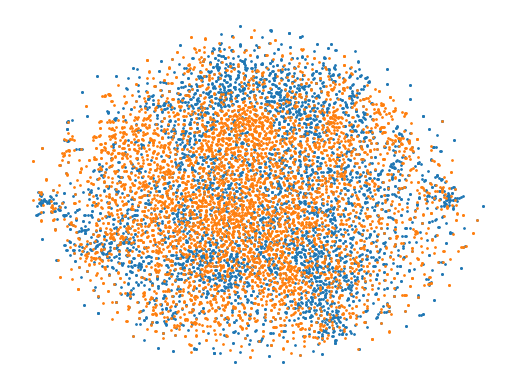

In [37]:
plt.scatter(X_2D[:codings_att1_1.shape[0], 0], X_2D[:codings_att1_1.shape[0], 1], s=1)
plt.scatter(X_2D[codings_att1_1.shape[0]:, 0], X_2D[codings_att1_1.shape[0]:, 1], s=1)
plt.axis('off');

## Creating vector feature

In here, we will calculate vector about atribute that we want insert. In this, we calculate Bald vector atribute and will insert in another images. The math about this trick is very simple! First, define your subset with True for your feature C, in another words: 

$$\mathcal{A}_{[C==1]} =\{ {\phi(x) ; X_c == 1}\}$$

Where $\phi(x) = z \in \mathbb{R}^{32}$ (The encoder of my autoencoder). And, the same idea for instances that C is False:

$$\mathcal{B}_{[C==0]} =\{ {\phi(x) ; X_c == 0}\}$$

In this context, we will undersample one of subsets to turn this sentence true: $n(\mathcal{A}_{[C==1]}) \approx n(\mathcal{B}_{[C==0]})$.

Then, we calculate two centroids, for each subsets: 

$$Cm_{A} = \frac{\sum_{x \in A} \phi(x)}{n(\mathcal{A}_{[C==1]})} $$

$$Cm_{B} = \frac{\sum_{x \in B} \phi(x)}{n(\mathcal{B}_{[C==0]})} $$

Finally, we can extract vector atribute:

$$\vec v = \vec Cm_{A} - \vec Cm_{B}$$

So, let's calculate this vector!


## Insert feature

In this context, we already have vector feature (yay!), so we can insert feature with this simple math: 

$$FakeImage = \psi(\phi(x) + t \cdot \vec v)$$

Where $x \in B$, $t \in \mathbb{R}$ and $\psi$ is decoder!

In [105]:
v_att1 = tf.reduce_mean(codings_att1_1, axis=0) - tf.reduce_mean(codings_att1_0, axis=0)

In [106]:
v_att1

<tf.Tensor: shape=(64,), dtype=float32, numpy=
array([ 0.2539301 ,  0.09232162, -0.14174981, -0.14260003, -0.09722528,
        0.00901634, -0.02083009,  0.10797875,  0.29824066,  0.06921408,
        0.06833181, -0.14762017, -0.04615718, -0.30447078,  0.17627932,
       -0.09896902,  0.10022691, -0.09343292,  0.10947654,  0.56363624,
       -0.05101812, -0.23766612,  0.22473139, -0.31781888, -0.10937947,
       -0.10685261, -0.15801242, -0.1586994 , -0.0804431 , -0.01797628,
        0.10052915, -0.07893813, -0.42312726, -0.80954576, -0.04854871,
        0.01403437, -0.15988666,  0.05014063,  0.25987816, -0.10051105,
        0.12465584, -0.0282817 , -0.19045699, -0.12763716,  0.06504668,
        0.28517097, -0.08213264, -0.24234742,  0.13665695, -0.0060524 ,
        0.02255367,  0.17886592,  0.03404546, -0.6594218 ,  0.00697456,
        0.03122091, -0.05524701,  0.17195374,  0.07702215, -0.23614219,
       -0.37979954,  0.13956633, -0.07351151, -0.06146346], dtype=float32)>

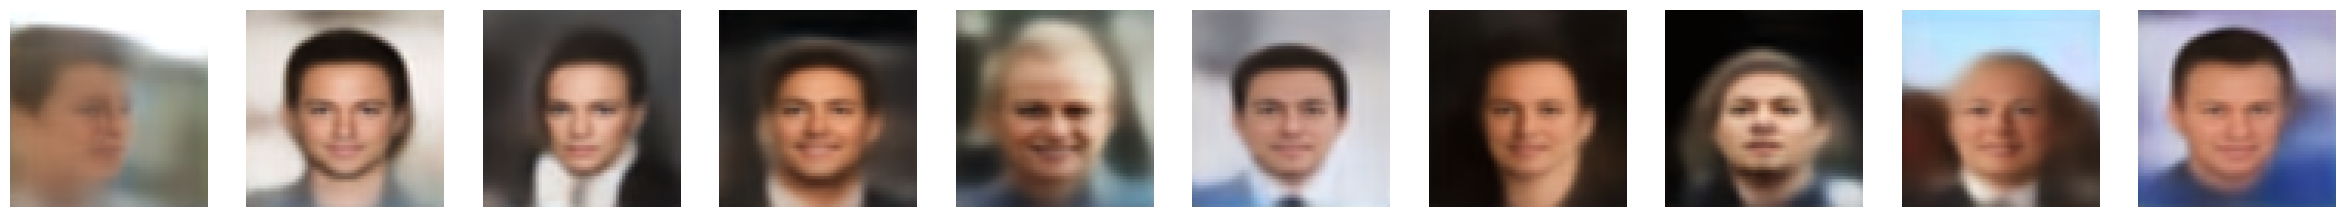

In [107]:
plot_multiple_images(variational_decoder(codings_att1_0[:10]), k=3)

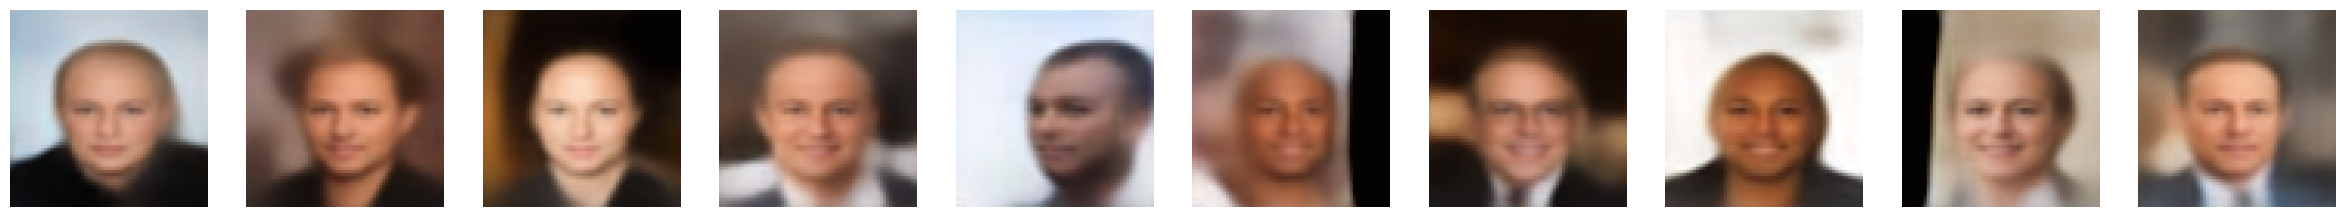

In [108]:
plot_multiple_images(variational_decoder(codings_att1_1[:10]), k=3)

In [109]:
def plot_multiple_images_tag(images, n_cols=None, k=1, tag=False, ts=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = images.squeeze(axis=-1)
    plt.figure(figsize=(n_cols * k, n_rows * k))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        
        clear_output()
        if tag and ts:
            plt.title(f'Reconstructed: {tag}, t={ts[index]}')
        elif tag and not ts:
            plt.title(f'Reconstructed: {tag}')
        plt.axis("off")

In [134]:
i = 43
delta = 1
k = 4
t = 0.8
fake_imgs = []
ts = [0.2, 0.5, 0.8, 1.1, 1.4, 1.7]
for t in ts:
    fake_imgs.append((codings_att1_0[i:i + delta] + t * v_att1)[0])
fake_imgs = tf.convert_to_tensor(np.array(fake_imgs))

original_imgs = []
for t in ts:
    original_imgs.append((codings_att1_0[i:i + delta] + 0.0 * v_att1)[0])
original_imgs = tf.convert_to_tensor(np.array(original_imgs))

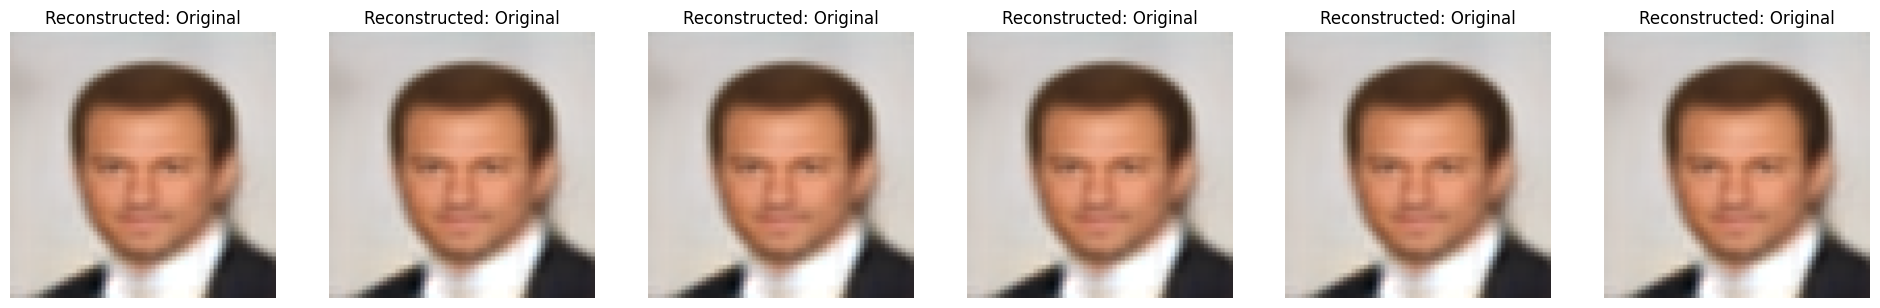

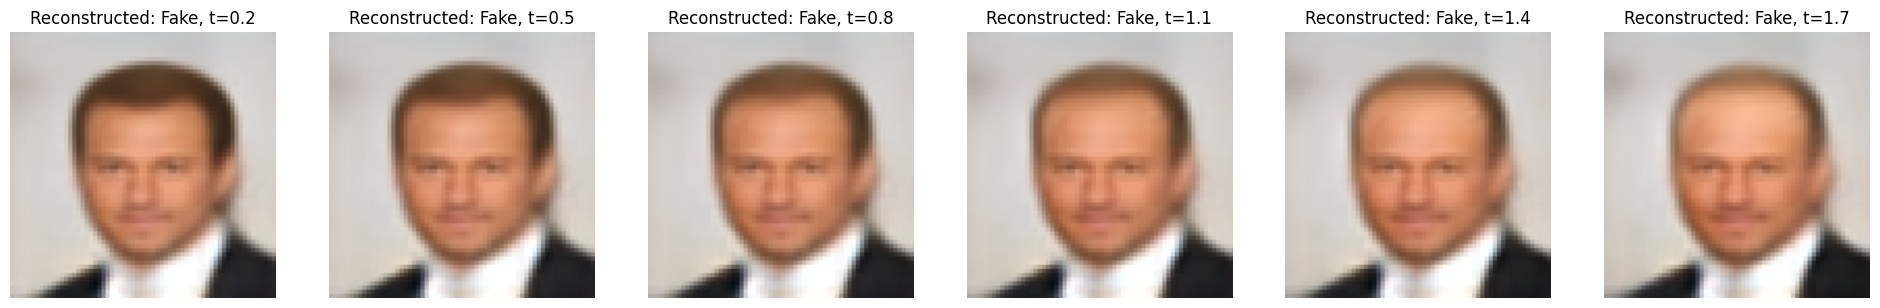

In [135]:
idx = 0
for X_ds in ds_Bald_att_0.batch(20).prefetch(1).take(1):
    plot_multiple_images_tag(variational_decoder(original_imgs), len(ts), k=k, tag='Original')
    plot_multiple_images_tag(variational_decoder(fake_imgs), len(ts), k=k, tag='Fake', ts=ts)
    idx += 1

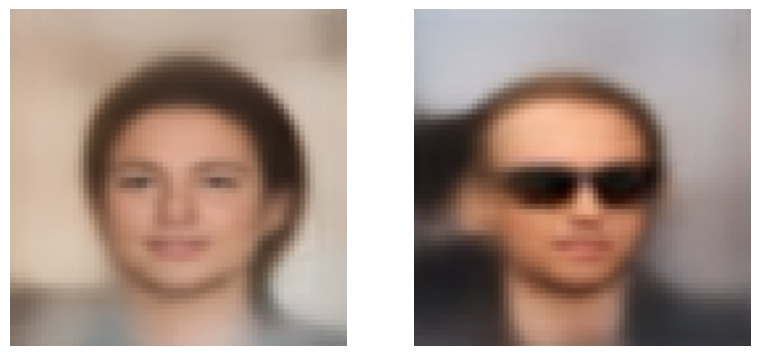

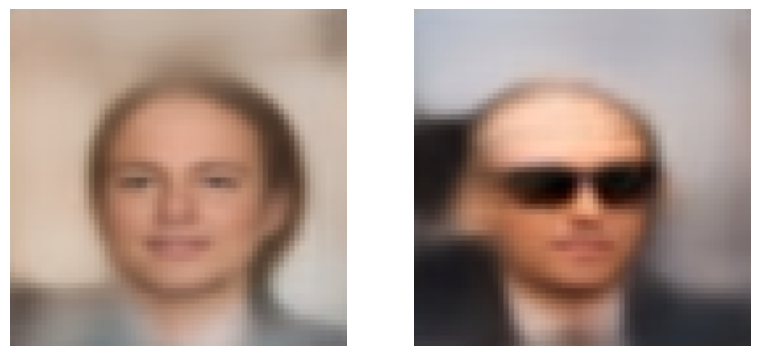

In [136]:
i = 257
delta = 2
fake_imgs = codings_att1_0[i:i + delta] + 1.0 * v_att1
for X_ds in ds_Bald_att_0.batch(20).prefetch(1).take(1):
    plot_multiple_images(variational_decoder(codings_att1_0[i:i + delta]), 4, k=5)
    plot_multiple_images(variational_decoder(fake_imgs), 4, k=5)

## Get all vector atributes

We have 42 features, so we can calculate 42 vector atributes. Let's choose some features and calculate vectors of them!

In [140]:
df.columns

Index(['image_id', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive',
       'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose',
       'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows',
       'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair',
       'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open',
       'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin',
       'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns',
       'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings',
       'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace',
       'Wearing_Necktie', 'Young', 'path'],
      dtype='object')

In [144]:
feats_get_vec = ['Bald', 'Eyeglasses', 'Chubby', 'Mouth_Slightly_Open', 'Mustache', 'Wearing_Earrings', 'Smiling']

In [146]:
for column in feats_get_vec:
    print('--------------------')
    print(df[column].value_counts(True))
    print(df[column].value_counts())
    print('--------------------')

--------------------
-1    0.977557
 1    0.022443
Name: Bald, dtype: float64
-1    198052
 1      4547
Name: Bald, dtype: int64
--------------------
--------------------
-1    0.934881
 1    0.065119
Name: Eyeglasses, dtype: float64
-1    189406
 1     13193
Name: Eyeglasses, dtype: int64
--------------------
--------------------
-1    0.942433
 1    0.057567
Name: Chubby, dtype: float64
-1    190936
 1     11663
Name: Chubby, dtype: int64
--------------------
--------------------
-1    0.516572
 1    0.483428
Name: Mouth_Slightly_Open, dtype: float64
-1    104657
 1     97942
Name: Mouth_Slightly_Open, dtype: int64
--------------------
--------------------
-1    0.958455
 1    0.041545
Name: Mustache, dtype: float64
-1    194182
 1      8417
Name: Mustache, dtype: int64
--------------------
--------------------
-1    0.811075
 1    0.188925
Name: Wearing_Earrings, dtype: float64
-1    164323
 1     38276
Name: Wearing_Earrings, dtype: int64
--------------------
--------------------
-

In [147]:
Bald_att_1 = tf.data.Dataset.from_tensor_slices(df[df['Bald'] ==  1]['path'].values[:5000])
Bald_att_0 = tf.data.Dataset.from_tensor_slices(df[(df['Bald'] == -1) & (df['Male'] == 1)]['path'].values[:5000])

Eyeglasses_att_1 = tf.data.Dataset.from_tensor_slices(df[df['Eyeglasses'] ==  1]['path'].values[:13193])
Eyeglasses_att_0 = tf.data.Dataset.from_tensor_slices(df[(df['Eyeglasses'] == -1)]['path'].values[:13193])

Chubby_att_1 = tf.data.Dataset.from_tensor_slices(df[df['Chubby'] ==  1]['path'].values[:11663])
Chubby_att_0 = tf.data.Dataset.from_tensor_slices(df[(df['Chubby'] == -1)]['path'].values[:11663])

Mouth_Slightly_Open_att_1 = tf.data.Dataset.from_tensor_slices(df[df['Mouth_Slightly_Open'] ==  1]['path'].values[:97942])
Mouth_Slightly_Open_att_0 = tf.data.Dataset.from_tensor_slices(df[(df['Mouth_Slightly_Open'] == -1)]['path'].values[:97942])

Mustache_att_1 = tf.data.Dataset.from_tensor_slices(df[df['Mustache'] ==  1]['path'].values[:8417])
Mustache_att_0 = tf.data.Dataset.from_tensor_slices(df[(df['Mustache'] == -1) & (df['Male'] == 1)]['path'].values[:8417])

Wearing_Earrings_att_1 = tf.data.Dataset.from_tensor_slices(df[df['Wearing_Earrings'] ==  1]['path'].values[:38276])
Wearing_Earrings_att_0 = tf.data.Dataset.from_tensor_slices(df[(df['Wearing_Earrings'] == -1)]['path'].values[:38276])

Smiling_att_1 = tf.data.Dataset.from_tensor_slices(df[df['Smiling'] ==  1]['path'].values[:97669])
Smiling_att_0 = tf.data.Dataset.from_tensor_slices(df[(df['Smiling'] == -1)]['path'].values[:97669])

In [148]:
'''

We will here slice 2 subsets of all dataset.

'''


def open_image(x):
    return tf.ensure_shape(tf.image.decode_image(tf.io.read_file(x)), [218, 178, 3])

def resize_image(x, n_outputs=2):
    if n_outputs == 2:
        return (tf.image.resize(x, [128, 128]) / 255., tf.image.resize(x, [128, 128]) / 255.)
    elif n_outputs == 1:
        return tf.image.resize(x, [128, 128]) / 255.
    return 


ds_Bald_att_1 = Bald_att_1.map(
    lambda x: resize_image(open_image(x))
)

ds_Bald_att_0 = Bald_att_0.map(
    lambda x: resize_image(open_image(x))
)

#----------------------------------------

ds_Eyeglasses_att_1 = Eyeglasses_att_1.map(
    lambda x: resize_image(open_image(x))
)

ds_Eyeglasses_att_0 = Eyeglasses_att_0.map(
    lambda x: resize_image(open_image(x))
)

#----------------------------------------

ds_Chubby_att_1 = Chubby_att_1.map(
    lambda x: resize_image(open_image(x))
)

ds_Chubby_att_0 = Chubby_att_0.map(
    lambda x: resize_image(open_image(x))
)

#----------------------------------------

ds_Mouth_Slightly_Open_att_1 = Mouth_Slightly_Open_att_1.map(
    lambda x: resize_image(open_image(x))
)

ds_Mouth_Slightly_Open_att_0 = Mouth_Slightly_Open_att_0.map(
    lambda x: resize_image(open_image(x))
)

#----------------------------------------

ds_Mustache_att_1 = Mustache_att_1.map(
    lambda x: resize_image(open_image(x))
)

ds_Mustache_att_0 = Mustache_att_0.map(
    lambda x: resize_image(open_image(x))
)

#----------------------------------------

ds_Wearing_Earrings_att_1 = Wearing_Earrings_att_1.map(
    lambda x: resize_image(open_image(x))
)

ds_Wearing_Earrings_att_0 = Wearing_Earrings_att_0.map(
    lambda x: resize_image(open_image(x))
)

#----------------------------------------

ds_Smiling_att_1 = Smiling_att_1.map(
    lambda x: resize_image(open_image(x))
)

ds_Smiling_att_0 = Smiling_att_0.map(
    lambda x: resize_image(open_image(x))
)

In [149]:
'''

Let's encode all images!

'''

_, _, codings_att1_1 = variational_encoder.predict(ds_Bald_att_1.batch(32).prefetch(1))
_, _, codings_att1_0 = variational_encoder.predict(ds_Bald_att_0.batch(32).prefetch(1))

_, _, codings_att2_1 = variational_encoder.predict(ds_Eyeglasses_att_1.batch(32).prefetch(1))
_, _, codings_att2_0 = variational_encoder.predict(ds_Eyeglasses_att_0.batch(32).prefetch(1))

_, _, codings_att3_1 = variational_encoder.predict(ds_Chubby_att_1.batch(32).prefetch(1))
_, _, codings_att3_0 = variational_encoder.predict(ds_Chubby_att_0.batch(32).prefetch(1))

_, _, codings_att4_1 = variational_encoder.predict(ds_Mouth_Slightly_Open_att_1.batch(32).prefetch(1))
_, _, codings_att4_0 = variational_encoder.predict(ds_Mouth_Slightly_Open_att_0.batch(32).prefetch(1))

_, _, codings_att5_1 = variational_encoder.predict(ds_Mustache_att_1.batch(32).prefetch(1))
_, _, codings_att5_0 = variational_encoder.predict(ds_Mustache_att_0.batch(32).prefetch(1))

_, _, codings_att6_1 = variational_encoder.predict(ds_Wearing_Earrings_att_1.batch(32).prefetch(1))
_, _, codings_att6_0 = variational_encoder.predict(ds_Wearing_Earrings_att_0.batch(32).prefetch(1))

_, _, codings_att7_1 = variational_encoder.predict(ds_Smiling_att_1.batch(32).prefetch(1))
_, _, codings_att7_0 = variational_encoder.predict(ds_Smiling_att_0.batch(32).prefetch(1))


3053/3053 [==============================] - 22s 7ms/step


In [150]:
all_codings_att1 = np.concatenate((codings_att1_1, codings_att1_0), axis=0)
all_codings_att2 = np.concatenate((codings_att2_1, codings_att2_0), axis=0)
all_codings_att3 = np.concatenate((codings_att3_1, codings_att3_0), axis=0)
all_codings_att4 = np.concatenate((codings_att4_1, codings_att4_0), axis=0)
all_codings_att5 = np.concatenate((codings_att5_1, codings_att5_0), axis=0)
all_codings_att6 = np.concatenate((codings_att6_1, codings_att6_0), axis=0)
all_codings_att7 = np.concatenate((codings_att7_1, codings_att7_0), axis=0)

In [153]:
'''

If you want just get data, set training_tsne false!

'''

training_tsne = False
if training_tsne:
    tsne_att1 = TSNE(init='pca')
    X_2D_att1 = tsne.fit_transform(all_codings_att1)

    tsne_att2 = TSNE(init='pca')
    X_2D_att2 = tsne.fit_transform(all_codings_att2)

    tsne_att3 = TSNE(init='pca')
    X_2D_att3 = tsne.fit_transform(all_codings_att3)

    tsne_att4 = TSNE(init='pca')
    X_2D_att4 = tsne.fit_transform(all_codings_att4)

    tsne_att5 = TSNE(init='pca')
    X_2D_att5 = tsne.fit_transform(all_codings_att5)

    tsne_att6 = TSNE(init='pca')
    X_2D_att6 = tsne.fit_transform(all_codings_att6)

    tsne_att7 = TSNE(init='pca')
    X_2D_att7 = tsne.fit_transform(all_codings_att7)
    
    for x in ['X_2D_att1', 'X_2D_att2', 'X_2D_att3', 'X_2D_att4', 'X_2D_att5', 'X_2D_att6', 'X_2D_att7']:
        pd.DataFrame(X_2D_att1).to_csv(f'./tsne_data/{x}.csv')
else:
    X_2D_att1 = pd.read_csv('./tsne_data/X_2D_att1.csv')
    X_2D_att2 = pd.read_csv('./tsne_data/X_2D_att2.csv')
    X_2D_att3 = pd.read_csv('./tsne_data/X_2D_att3.csv')
    X_2D_att4 = pd.read_csv('./tsne_data/X_2D_att4.csv')
    X_2D_att5 = pd.read_csv('./tsne_data/X_2D_att5.csv')
    X_2D_att6 = pd.read_csv('./tsne_data/X_2D_att6.csv')
    X_2D_att7 = pd.read_csv('./tsne_data/X_2D_att7.csv')

C:\Users\gabri\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\gabri\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
C:\Users\gabri\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\gabri\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
C:\Users\gabri\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 2

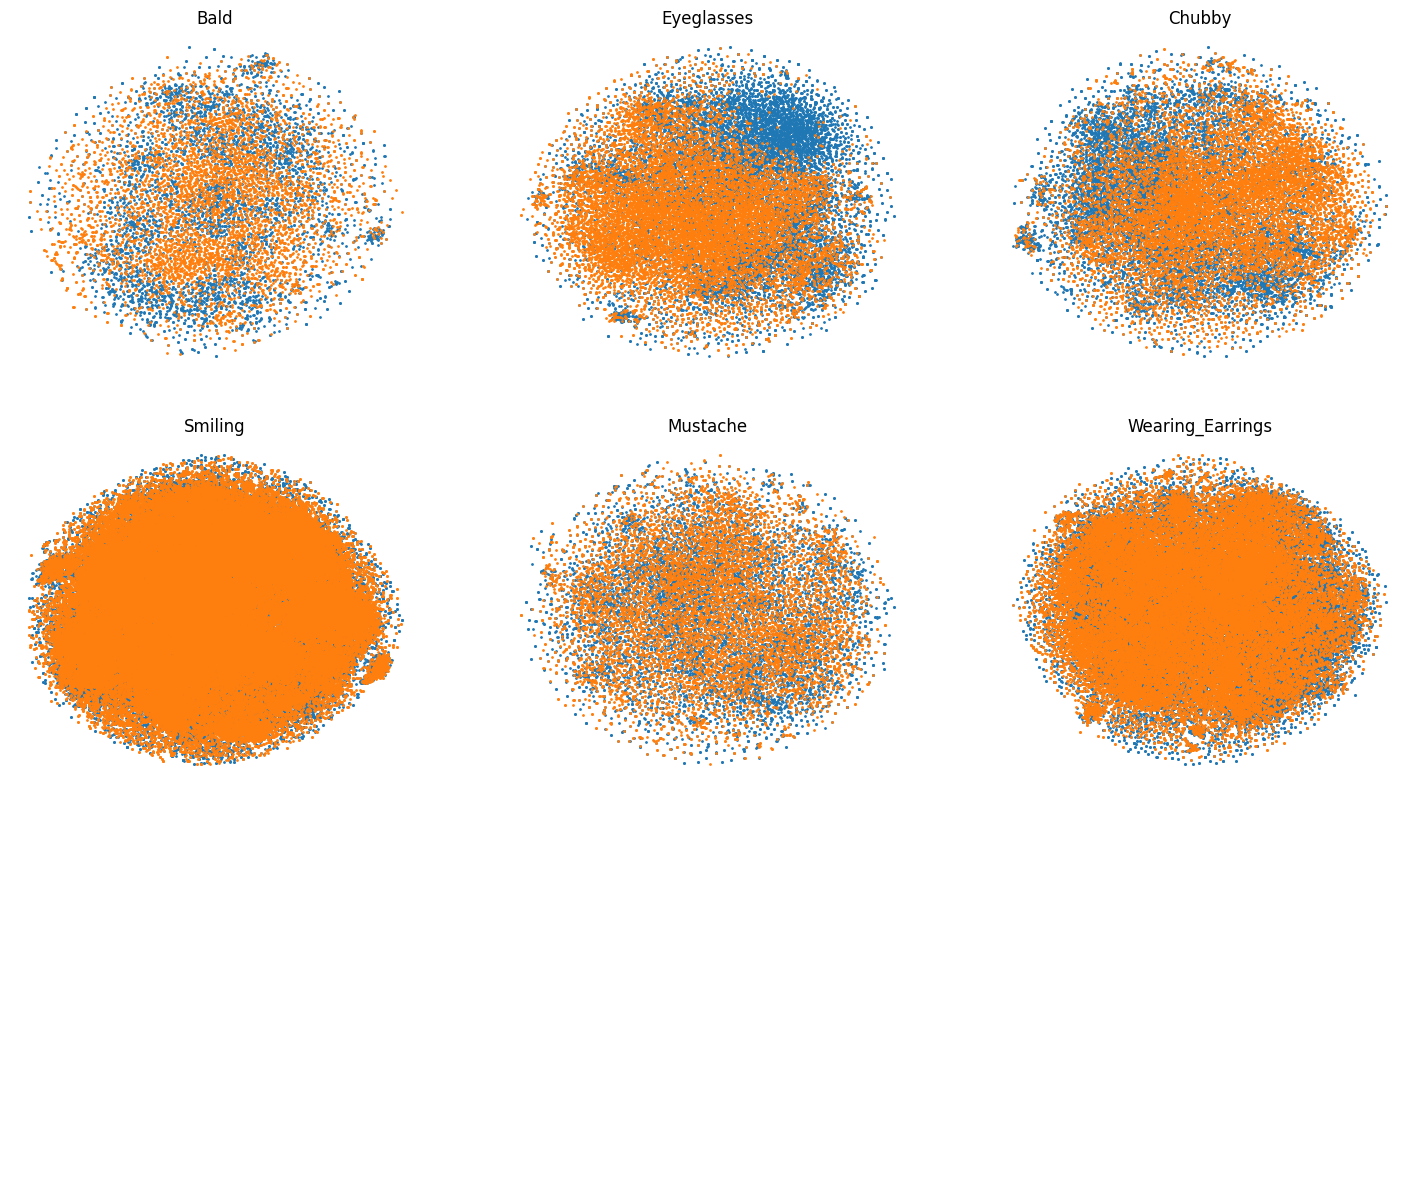

In [175]:
fig, ax = plt.subplots(3, 3, figsize=(18, 15))

ax[0, 0].scatter(X_2D_att1[:codings_att1_1.shape[0], 0], X_2D_att1[:codings_att1_1.shape[0], 1], s=1)
ax[0, 0].scatter(X_2D_att1[codings_att1_1.shape[0]:, 0], X_2D_att1[codings_att1_1.shape[0]:, 1], s=1)
ax[0, 0].set_title('Bald')
ax[0, 0].axis('off')


ax[0, 1].scatter(X_2D_att2[:codings_att2_1.shape[0], 0], X_2D_att2[:codings_att2_1.shape[0], 1], s=1)
ax[0, 1].scatter(X_2D_att2[codings_att2_1.shape[0]:, 0], X_2D_att2[codings_att2_1.shape[0]:, 1], s=1)
ax[0, 1].set_title('Eyeglasses')
ax[0, 1].axis('off')

ax[0, 2].scatter(X_2D_att3[:codings_att3_1.shape[0], 0], X_2D_att3[:codings_att3_1.shape[0], 1], s=1)
ax[0, 2].scatter(X_2D_att3[codings_att3_1.shape[0]:, 0], X_2D_att3[codings_att3_1.shape[0]:, 1], s=1)
ax[0, 2].set_title('Chubby')
ax[0, 2].axis('off')

# ax[1, 0].scatter(X_2D_att4[:codings_att4_1.shape[0], 0], X_2D_att4[:codings_att4_1.shape[0], 1], s=1)
# ax[1, 0].scatter(X_2D_att4[codings_att4_1.shape[0]:, 0], X_2D_att4[codings_att4_1.shape[0]:, 1], s=1)
# ax[1, 0].set_title('Mouth_Slightly_Open')
ax[1, 0].axis('off')

ax[1, 1].scatter(X_2D_att5[:codings_att5_1.shape[0], 0], X_2D_att5[:codings_att5_1.shape[0], 1], s=1)
ax[1, 1].scatter(X_2D_att5[codings_att5_1.shape[0]:, 0], X_2D_att5[codings_att5_1.shape[0]:, 1], s=1)
ax[1, 1].set_title('Mustache')
ax[1, 1].axis('off')

ax[1, 2].scatter(X_2D_att6[:codings_att6_1.shape[0], 0], X_2D_att6[:codings_att6_1.shape[0], 1], s=1)
ax[1, 2].scatter(X_2D_att6[codings_att6_1.shape[0]:, 0], X_2D_att6[codings_att6_1.shape[0]:, 1], s=1)
ax[1, 2].set_title('Wearing_Earrings')
ax[1, 2].axis('off')

ax[1, 0].scatter(X_2D_att7[:codings_att7_1.shape[0], 0], X_2D_att7[:codings_att7_1.shape[0], 1], s=1)
ax[1, 0].scatter(X_2D_att7[codings_att7_1.shape[0]:, 0], X_2D_att7[codings_att7_1.shape[0]:, 1], s=1)
ax[1, 0].set_title('Smiling')
ax[2, 0].axis('off')

ax[2, 1].axis('off')
ax[2, 2].axis('off')

plt.show()

In [176]:
v_att1 = tf.reduce_mean(codings_att1_1, axis=0) - tf.reduce_mean(codings_att1_0, axis=0)
v_att2 = tf.reduce_mean(codings_att2_1, axis=0) - tf.reduce_mean(codings_att2_0, axis=0)
v_att3 = tf.reduce_mean(codings_att3_1, axis=0) - tf.reduce_mean(codings_att3_0, axis=0)
v_att4 = tf.reduce_mean(codings_att4_1, axis=0) - tf.reduce_mean(codings_att4_0, axis=0)
v_att5 = tf.reduce_mean(codings_att5_1, axis=0) - tf.reduce_mean(codings_att5_0, axis=0)
v_att6 = tf.reduce_mean(codings_att6_1, axis=0) - tf.reduce_mean(codings_att6_0, axis=0)
v_att7 = tf.reduce_mean(codings_att7_1, axis=0) - tf.reduce_mean(codings_att7_0, axis=0)

In [213]:
def plot_multiple_images_tag(images, n_cols=None, k=1, tag=False, ts=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = images.squeeze(axis=-1)
    plt.figure(figsize=(n_cols * k, n_rows * k))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        
        clear_output()
        if tag and ts:
            plt.title(f'{tag}, t={ts[index]}')
        elif tag and not ts:
            plt.title(f'{tag}')
        plt.axis("off")

In [245]:
i = 43
delta = 1
k = 4
t = 0.8
fake_imgs_7_1 = []
fake_imgs_7 = []
fake_imgs_5 = []
fake_imgs_2 = []
fake_imgs_1_5_7 = []


ts = [0.2, 0.5, 0.8, 1.1, 1.4, 1.7]

for t in ts:
    fake_imgs_7_1.append((codings_att1_0[i:i + delta] + t * v_att7 + t * v_att1)[0])
fake_imgs_7_1 = tf.convert_to_tensor(np.array(fake_imgs_7_1))

for t in ts:
    fake_imgs_7.append((codings_att1_0[i:i + delta] + t * v_att7)[0])
fake_imgs_7 = tf.convert_to_tensor(np.array(fake_imgs_7))

for t in ts:
    fake_imgs_5.append((codings_att1_0[i:i + delta] + t * v_att5 * 2.0)[0])
fake_imgs_5 = tf.convert_to_tensor(np.array(fake_imgs_5))

for t in [0.2, 0.5, 0.8, 1.1, 1.4, 4.1]:
    fake_imgs_2.append((codings_att1_0[i:i + delta] + t * v_att2)[0])
fake_imgs_2 = tf.convert_to_tensor(np.array(fake_imgs_2))

for t in ts:
    fake_imgs_1_5_7.append((codings_att1_0[i:i + delta] + t * v_att1 + t * v_att5 * 4.0 + t * v_att7)[0])
fake_imgs_1_5_7 = tf.convert_to_tensor(np.array(fake_imgs_1_5_7))

original_imgs = []
for t in ts:
    original_imgs.append((codings_att1_0[i:i + delta] + 0.0 * v_att7 + 0.0 * v_att1)[0])
original_imgs = tf.convert_to_tensor(np.array(original_imgs))

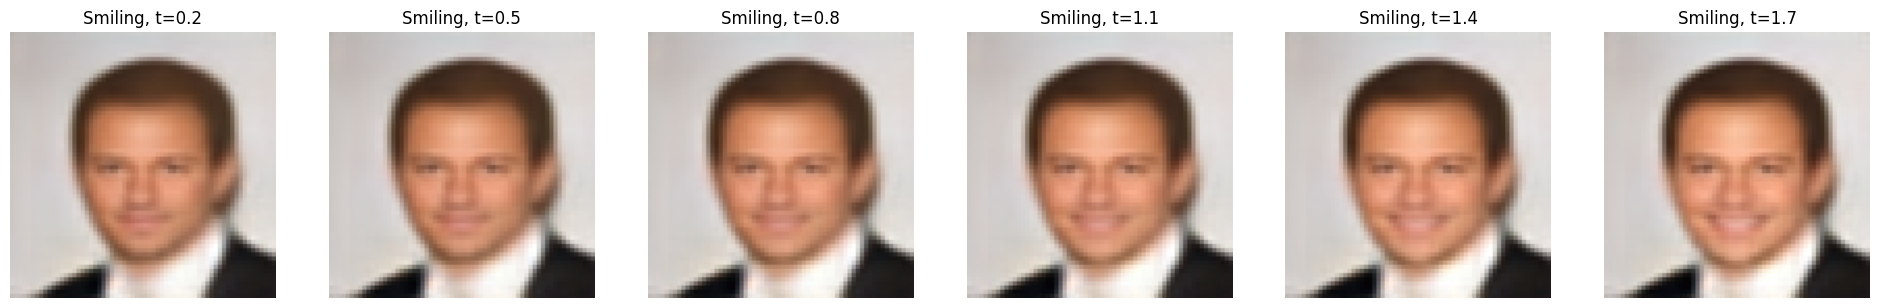

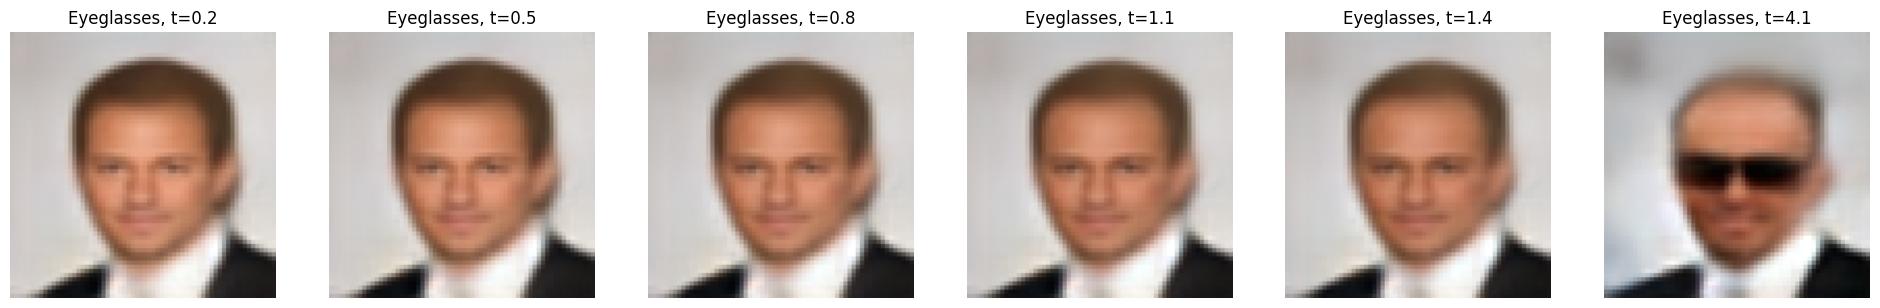

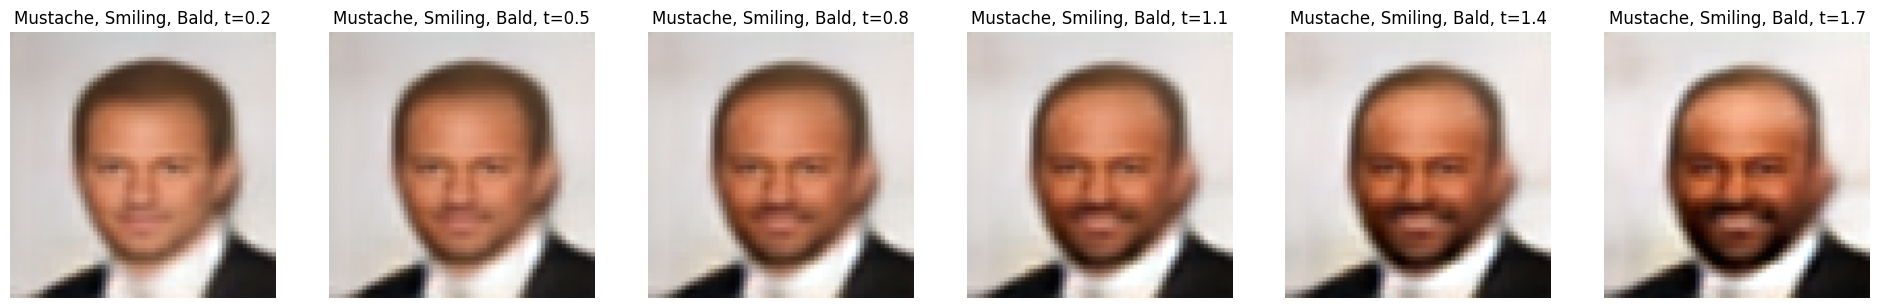

In [246]:
idx = 0
for X_ds in ds_Bald_att_0.batch(20).prefetch(1).take(1):
    plot_multiple_images_tag(variational_decoder(original_imgs), len(ts), k=k, tag='Original')
    plot_multiple_images_tag(variational_decoder(fake_imgs_7_1), len(ts), k=k, tag='Smiling, Bald', ts=ts)
    plot_multiple_images_tag(variational_decoder(fake_imgs_7), len(ts), k=k, tag='Smiling', ts=ts)
    plot_multiple_images_tag(variational_decoder(fake_imgs_5), len(ts), k=k, tag='Mustache', ts=ts)
    plot_multiple_images_tag(variational_decoder(fake_imgs_2), len(ts), k=k, tag='Eyeglasses', ts=[0.2, 0.5, 0.8, 1.1, 1.4, 4.1])
    plot_multiple_images_tag(variational_decoder(fake_imgs_1_5_7), len(ts), k=k, tag='Mustache, Smiling, Bald', ts=ts)
    
    idx += 1

# Conclusion: Exploring the Implications of Feature Insertion in the CelebA Dataset

This tutorial provides a fascinating insight into image manipulation in the popular CelebA dataset, allowing the insertion of various features such as smiles, baldness, and glasses. The implications of this work are diverse and far-reaching, impacting both the field of computer vision and ethical considerations related to visual data manipulation.

1. Advancement of Image Generation Techniques:
By demonstrating the insertion of features into existing images, this work contributes to the advancement of image generation techniques. This approach can be valuable for training generative models capable of creating realistic variations in facial characteristics, with applications in character design and digital content production.

2. Exploration of Creative Possibilities:
The ability to add or modify features in images offers significant creative space. This can be explored in design, advertising, and entertainment environments, where the customization of images is a growing trend. Companies can use these techniques to create more impactful and engaging advertising campaigns.

3. Ethical Considerations and Responsibility:
However, it is imperative to address the ethical implications related to image manipulation, especially when dealing with recognizable data of individuals. Issues of consent, privacy, and fair representation must be carefully considered to avoid potential abuses and negative impacts.

4. Reflection on Beauty Standards and Identity:
The ability to modify facial features raises questions about beauty standards and identity. This work can serve as a platform for reflection on how visual representations impact societal perceptions of beauty and identity, encouraging constructive discussions on diversity and inclusion.

5. Development of Interactive Tools:
This tutorial may inspire the development of interactive tools that allow users to explore and experiment with facial features. This could have applications in sectors such as social media, where the customization of avatars and photos is common.

6. Promotion of Education in Computer Vision:
By sharing this knowledge through a tutorial, it contributes to education in computer vision. This can inspire students and professionals to explore innovative approaches to image manipulation and broaden their horizons in the field.

In summary, the insertion of features into images from the CelebA dataset presents exciting opportunities and challenges the community to consider the ethical and social implications of these techniques. Responsible application of these tools is crucial to ensure ethical and beneficial use in society.